In [1]:
# Loading Libraries:

In [2]:
import tensorflow as tf
from tensorflow import keras
import csv
import pandas as pd
import random
from sklearn.datasets import load_files
import numpy as np
import matplotlib.pyplot as plt
import os
import glob


#additional libraries may be necessary further along

Code to combine all CSV files in our folder to one large CSV file 

In [3]:
#all data combined into one CSV
from os import chdir

chdir(r"C:/Users/120A-1/Documents/New_DataNN/Data/Classification_NewDataOnly")
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv(r"C:/Users/120A-1/Documents/New_DataNN/Data/Classification_NewDataOnly/Classification_Data_csv.csv", index=False, encoding='utf-8-sig')

Converting data from the large CSV file into an array:

In [4]:
import pandas as pd #already called on in first cell

Df = pd.read_csv(r"C:/Users/120A-1/Documents/New_DataNN/Data/Classification_NewDataOnly/Classification_Data_csv.csv")
dataset = Df.values

The code below splits the voltage data where time is equal to zero and then splits them for 36 second batches. The 36 second batches accounts for "multiple sample issue" and deletes any that are not equal in length:

In [ ]:
import numpy as np #already called on in the first cell
from scipy.fftpack import fft
from scipy import signal
from scipy.signal import lfilter
#g = [1, 4, 4, -4, -10, -4, 4, 4, 1]
X = dataset[:,1:4] #an array of removing the string values in dataset

timeArr = X[:,1] #an array of the time series data from X
new = np.array([])
a = np.where(timeArr == 0)[0]  
c = np.split(X, a , axis=0)
del c[0] #splits into data cycles
xNew = []
yNew = []
result_array = np.array([])

for i in range(len(c)):
    timeBatch = c[i][:, 1]
    eachBatch = np.where(timeBatch % 36 == 0)[0] #splits into each 36 second data sample
    splitBatch = np.split(c[i], eachBatch, axis = 0)
    del splitBatch[0]
    #print(len(splitBatch2))
    #print(len(splitBatch))
for p in range (len(splitBatch)-1):
        timeBatch2 = splitBatch[p][:, 1]
        eachBatch2 = np.where(timeBatch2 % 26 == 0)[0] #splits into each 36 second data sample
        splitBatch2 = np.split(splitBatch[p], [260], axis = 0)
        result_array = np.append(result_array, splitBatch2)
        #print(len(splitBatch2))
        #del splitBatch2[1]
        #splitBatch2 = np.array(splitBatch2)
        #print(result_array)
        #print(len(result_array))
        for j in range (len(result_array)):
            eachX = []
            eachSD = []
            eachFFT =[]
            eachPower =[]
            #print(splitBatch2)
            #print(len(splitBatch2))
            if len(result_array[j]) == 260:
                eachX.append(result_array[j][:, 0]) #appends each sample as an array within the array of cycles
                eachSD = np.std(eachX)
                eachFFT = fft(eachX)
                #eachFilter = lfilter(g, 1, eachX)
                eachX.append(eachSD) #appends each cycle to xNew array
                eachX.append(eachFFT)
                #eachX.append(eachFilter)
                xNew.append(eachX)
                yNew.append(result_array[j][:, 2])
            else:
                np.delete(result_array, j) #splits into 36 seconds keeping all in the same sample and removing all that are not 360 datapoints

A = pd.DataFrame(xNew)
B = pd.DataFrame(yNew)
frames = [A,B]
result = pd.concat(frames) #dataframe made of the multiple 36 second batches and their labels
result

Code below makes the dataframe into an array and creates two arrays of features and labels. Reshaping of features to combine them all into one array.

In [16]:
Array22 = result.values #making result into an array
X = Array22[0:3657,0] #raw data feature
W = Array22[0:3657,1] #standard deviation feature
Z = Array22[0:3657,2] #fourier transform feature
Y = Array22[3657:,0] #labels

#reshape features to feed into model
xT =X.reshape(-1, 1)
XX = np.vstack(X)
ZZ =Z.reshape(-1, 1)
ZZ = np.vstack(Z)
ZZZ = abs(ZZ)

WW = W.reshape(-1, 1)
#Array100 = np.concatenate(XX)
Array100=np.concatenate((XX,WW,ZZZ),axis=1)
#len(Array100)

Loading more libraries:

In [17]:
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.layers import concatenate

1) Normalizing features to 0 to 1
2) Randomizing and splitting data into training, validation, and testing data
3) Creating the architecture and evaluating the accuracy

In [24]:

# univariate cnn example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

#1
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(ZZZ)


#2
from sklearn.model_selection import train_test_split
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

model = Sequential([    Dense(2, activation='relu', input_shape=(360,)),    Dense(2, activation='relu'),    Dense(1, activation='sigmoid'),])
model.compile(optimizer='sgd',              loss='binary_crossentropy',              metrics=['accuracy'])
hist = model.fit(X_train, Y_train,          batch_size=32, epochs=100,          validation_data=(X_val, Y_val))
model.evaluate(X_test, Y_test)[1]    

(2559, 360) (549, 360) (549, 360) (2559,) (549,) (549,)
Train on 2559 samples, validate on 549 samples
Epoch 1/100
2559/2559 [==============================] - 1s 207us/step - loss: 0.4574 - acc: 0.7644 - val_loss: 0.3966 - val_acc: 0.7632
Epoch 2/100
2559/2559 [==============================] - 0s 30us/step - loss: 0.3770 - acc: 0.7644 - val_loss: 0.3640 - val_acc: 0.7632
Epoch 3/100
2559/2559 [==============================] - 0s 29us/step - loss: 0.3453 - acc: 0.7644 - val_loss: 0.3317 - val_acc: 0.7632
Epoch 4/100
2559/2559 [==============================] - 0s 29us/step - loss: 0.3134 - acc: 0.7800 - val_loss: 0.2990 - val_acc: 0.8051
Epoch 5/100
2559/2559 [==============================] - 0s 29us/step - loss: 0.2841 - acc: 0.8335 - val_loss: 0.2722 - val_acc: 0.8342
Epoch 6/100
2559/2559 [==============================] - 0s 29us/step - loss: 0.2614 - acc: 0.8718 - val_loss: 0.2514 - val_acc: 0.8944
Epoch 7/100
2559/2559 [==============================] - 0s 31us/step - loss: 0.

0.9981785063752276

Saved Model to Disk

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
#print("Saved model to disk")

Create arrays to pass into the confusion matrix that contain the model's predicted values and the correct values.

In [20]:
from sklearn.metrics import confusion_matrix

yhat_classes = model.predict_classes(X_test, verbose=0)
OPE = pd.DataFrame(yhat_classes)
OPEE = np.around(OPE,decimals=0)
OOPEE = OPEE.astype(int) #round predicted values to integer values (0 or 1)
Yhat = OOPEE.values
Yhat = Yhat.reshape(1, -1)
Y_HatHat = np.concatenate(Yhat)

y_pred = Y_HatHat.astype(int) #predicted values array
y_true = Y_test.astype(int) #correct values array


Create confusion matrix for a visual representation of the model's accuracy.

Confusion matrix, without normalization
[[139   0]
 [  6 404]]
Normalized confusion matrix
[[1.   0.  ]
 [0.01 0.99]]


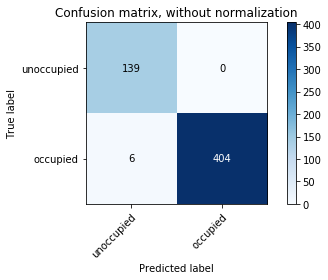

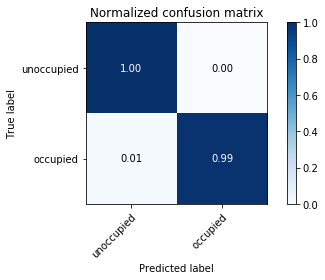

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

iris = datasets.load_iris() #dataset used to create unoccupied and occupied labels
iris.target_names[0] = 'unoccupied'
iris.target_names[1] = 'occupied'
class_names = iris.target_names

#used tensorflow function to print and plot the confusion matrix with the option of normalization
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
            
    cm = confusion_matrix(y_true, y_pred) #compute confusion matrix
    #classes = [1,2,3,4]
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] #creates normalized matrix
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots() #plots confusion matrix using imshow
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes, #add ticks and labels to the plot
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'  #add text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization') #not normalized confusion matrix

plot_confusion_matrix(y_true, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix') #normalized confusion matrix

plt.show()

Create report with f1 score

In [13]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97       117
           1       1.00      0.99      0.99       432

    accuracy                           0.99       549
   macro avg       0.98      0.99      0.98       549
weighted avg       0.99      0.99      0.99       549



Next two cells work to show our model visually:

In [14]:
#used to show our model visually
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 2)                 722       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 3         
Total params: 731
Trainable params: 731
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True) #file in folder CSV_Files

Visualizing loss and accuracy to see if there is overfitting in our data (tutorial):

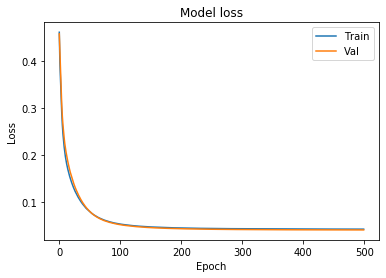

In [16]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()


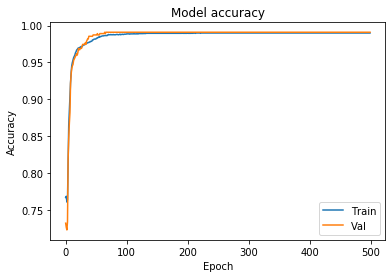

In [17]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()